In [35]:
import teaching
from teaching import TeacherExplainer

In [ ]:
import torch
import torch.optim as optim
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
import math

# Data Setup

As an illustrative setting where we can visually inspect the teaching set, we perform experiments on  two dimensional Gaussian mixture data.  The covariate space is $\mathcal{X}= \mathbb{R}^2$ and target $\mathcal{Y} = \{0,1\}$, we assume that there exists two  sub-populations in the data denoted $A=1$ and $A=0$.
Furthermore, $X|(Y=y,A=a)$ is normally distributed according to $ \mathcal{N}(\mu_{y,a}, I)$. The group proportion is $P(A=1) =0.5$ and the means are sampled from a uniform distribution. 
The AI follows the Bayes solution for group $A=1$ which here corresponds to a hyperplane and the human classifier follows the Bayes solution for group $A=0$, which is another hyperplane. We assume the human's prior rejector is to reject based on a tresholding of the predictor confidence i.e. $g_0(x) = I \{ ||h(x)|| \leq \epsilon \} $ .  We assume that the similarity kernel is the RBF kernel $K(x,x')= e^{-||x-x'||^2}$.

In [3]:

def sample(mu, var, nb_samples=500):
    """
    sample guassian data
    :param mu: torch.Tensor (features)
    :param var: torch.Tensor (features) (note: zero covariance)
    :return: torch.Tensor (nb_samples, features)
    """
    out = []
    for i in range(nb_samples):
        out += [
            torch.normal(mu, var.sqrt())
        ]
    return torch.stack(out, dim=0)

    

In [4]:

class Linear_net_sig(nn.Module):
    ''' linear classifier '''
    def __init__(self, input_dim):
        super(Linear_net_sig, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(input_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x

def run_classifier_sig(net, data_x, data_y, n_epochs = 10000):
    '''
    training code for linear classifier
    '''
    BCE = torch.nn.BCELoss(size_average=True)
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 1000*10000)
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        # get the inputs; data is a list of [inputs, labels]
        inputs = data_x
        labels = data_y
        order = np.array(range(len(data_x)))
        np.random.shuffle(order)
        # in-place changing of values
        inputs[np.array(range(len(data_x)))] = inputs[order]
        labels[np.array(range(len(data_x)))] = labels[order]
        # zero the parameter gradients

        # forward + backward + optimize
        outputs = net(inputs)[:,0]

        loss = BCE(outputs, labels*1.0) 

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()
        running_loss += loss.item()
        if epoch % 10000 == 0:
            print("loss " + str(loss.item()))

    #print('Finished Training')


def test_classifier_sig(net, data_x, data_y):
    ''' testing code for linear classifier'''
    correct = 0
    total = 0
    with torch.no_grad():
        inputs =  data_x
        labels = data_y
        outputs = net(inputs)
        predicted = torch.round(outputs.data)
        total = labels.size(0)
        for i in range(total):
            correct += predicted[i].item() == labels[i].item()
        #correct = (predicted == labels).sum()
    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    
def mscatter(x,y,ax=None, m=None, **kw):
    import matplotlib.markers as mmarkers
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc
def conv_to_color(arr):
    cols = []
    for a in arr:
        if a == 1:
            cols.append("blue")
        else:
            cols.append("red")
    return cols

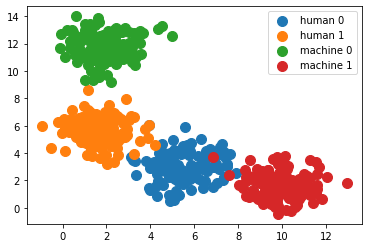

In [19]:
'''
generate data for each cluster
'''
torch.manual_seed(12)
d = 2
total_samples = 500
mean_scale = 12
variance = 1.0
group_proportion = 0.5

cluster1_mean = torch.rand(d)*mean_scale
cluster1_var = torch.tensor(variance)#torch.rand(d)*d
cluster1 = sample(
    cluster1_mean,
    cluster1_var,
    nb_samples= math.floor(total_samples * group_proportion * 0.5 )
)
cluster1_labels = torch.ones([math.floor(total_samples * group_proportion * 0.5 )], dtype=torch.long)
cluster2_mean = torch.rand(d)*mean_scale
cluster2_var = torch.tensor(variance)#torch.rand(d)*d
cluster2 = sample(
    cluster2_mean,
    cluster2_var,
    nb_samples= math.floor(total_samples * group_proportion * 0.5 )
)
cluster2_labels = torch.zeros([math.floor(total_samples * group_proportion * 0.5 )], dtype=torch.long)
cluster3_mean = torch.rand(d)*mean_scale
cluster3_var = torch.tensor(variance)#torch.rand(d)*d
cluster3 = sample(
    cluster3_mean,
    cluster3_var,
    nb_samples= math.floor(total_samples * (1-group_proportion) * 0.5 )
)
cluster3_labels = torch.ones([math.floor(total_samples * (1-group_proportion) * 0.5 )], dtype=torch.long)

cluster4_mean = torch.rand(d)*mean_scale
cluster4_var = torch.tensor(variance)#torch.rand(d)*d
cluster4 = sample(
    cluster4_mean,
    cluster4_var,
    nb_samples= math.floor(total_samples * (1-group_proportion) * 0.5 )
)
cluster4_labels = torch.zeros([math.floor(total_samples * (1-group_proportion) * 0.5 )], dtype=torch.long)

# test data
cluster1_test = sample(
    cluster1_mean,
    cluster1_var,
    nb_samples= math.floor(total_samples * group_proportion * 0.5 )
)
cluster1_labels_test = torch.ones([math.floor(total_samples * group_proportion * 0.5 )], dtype=torch.long)

cluster2_test = sample(
    cluster2_mean,
    cluster2_var,
    nb_samples= math.floor(total_samples * group_proportion * 0.5 )
)
cluster2_labels_test = torch.zeros([math.floor(total_samples * group_proportion * 0.5 )], dtype=torch.long)

cluster3_test = sample(
    cluster3_mean,
    cluster3_var,
    nb_samples= math.floor(total_samples * (1-group_proportion) * 0.5 )
)
cluster3_labels_test = torch.ones([math.floor(total_samples * (1-group_proportion) * 0.5 )], dtype=torch.long)

cluster4_test = sample(
    cluster4_mean,
    cluster4_var,
    nb_samples= math.floor(total_samples * (1-group_proportion) * 0.5 )
)
cluster4_labels_test = torch.zeros([math.floor(total_samples * (1-group_proportion) * 0.5 )], dtype=torch.long)

fig, ax = plt.subplots(1)
x1 = cluster1.numpy()
x2 = cluster2.numpy()
x3 = cluster3.numpy()
x4 = cluster4.numpy()
epsilon = 0.8
ax.set_facecolor('white')
#ax.set(xlim=(-4, 10), ylim=(-4, 10))
#ax.vlines([-12,-6,0,6,12.3],-12,12.3)
#ax.hlines([-12,-6,0,6,12.3],-12,12.3)
#ax.plot([x1h, x2h], [y1h, y2h], color='red', marker='x',label = "human")
#ax.plot([x1m, x2m], [y1m, y2m], color='blue', marker='x',label = "machine")

scatter = mscatter(x1[:, 0], x1[:, 1],  cmap='RdBu',  ax=ax,s=100, label="human 0")
scatter = mscatter(x2[:, 0], x2[:, 1], cmap='RdBu',  ax=ax,s=100, label="human 1")
scatter = mscatter(x3[:, 0], x3[:, 1],  cmap='RdBu',  ax=ax,s=100, label="machine 0")
scatter = mscatter(x4[:, 0], x4[:, 1],  cmap='RdBu',  ax=ax,s=100, label="machine 1")
plt.legend()
plt.show()

In [ ]:
print("Obtaining AI")
# AI is linear model on two clusters
net_machine = Linear_net_sig(d)
data_x = torch.cat([cluster3, cluster4])
data_y = torch.cat([cluster3_labels, cluster4_labels])
run_classifier_sig(net_machine, data_x, data_y, 50000)

print("Obtaining human")
# Human is linear model on remaining two clusters
net_human = Linear_net_sig(d)
data_x = torch.cat([cluster1, cluster2])
data_y = torch.cat([cluster1_labels, cluster2_labels])
run_classifier_sig(net_human, data_x, data_y, 50000)


In [21]:
data_x = torch.cat([cluster1, cluster2, cluster3, cluster4])
data_y = torch.cat([cluster1_labels, cluster2_labels, cluster3_labels, cluster4_labels])
data_x_np = data_x.numpy()
data_y_np = data_y.numpy()
outputs = net_human(data_x)
predicted_hum = torch.round(outputs.data).numpy()[:,0]
outputs = net_machine(data_x)
predicted_mach = torch.round(outputs.data).numpy()[:,0]

In [22]:
# prior human rejector thresholds the human's confidence to epsilon
prior_rejector = []
epsilon = 0.9
with torch.no_grad():
    inputs =  data_x
    labels = data_y
    outputs = net_human(inputs)
    predicted = torch.round(outputs.data)
    for i in range(len(inputs)):
        r_score = max(1 - outputs.data[i].item(), outputs.data[i].item())
        r = 0
        if r_score <  epsilon:
            r = 1
        else:
            r =  0
        prior_rejector.append(r)

In [23]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import accuracy_score
kernel = rbf_kernel # K(.,.)
metric_y = accuracy_score # metric


## Consistent Radius Teaching

Create teacher explainer

In [24]:
teacher = TeacherExplainer(data_x_np, data_y_np, predicted_hum, predicted_mach, prior_rejector, kernel, metric_y, 1, 5)

get teaching points

In [ ]:
teaching_x, teaching_gammas, teaching_labels, teaching_indices = teacher.get_teaching_examples(True)

In [26]:
# plotting helpers
def test_posterior(net_hum, net_mach, epsilon, knn_learner, data_x, data_y):
    correct = 0
    correct_sys = 0
    exp = 0
    exp_total = 0
    total = 0
    real_total = 0
    alone_correct = 0
    mistakes = []
    rejector_preds = []
    with torch.no_grad():
        inputs =  data_x
        labels = data_y
        m = net_mach(inputs)
        predicted_exp = torch.round(m.data)
        outputs = net_hum(inputs)
        predicted = torch.round(outputs.data)
        post_preds = knn_learner.predict(inputs.numpy(), teacher.prior_rejector_preds)
        for i in range(len(inputs)):
            r = post_preds[i]
            if r == -1: # if no point in  ball
                r_score = max(1 - outputs.data[i].item(), outputs.data[i].item())
                if r_score <  epsilon:
                    r = 1
                else:
                    r =  0
            rejector_preds.append(r)
            if r == 1:
                exp += (predicted_exp[i] == labels[i]).item()
                correct_sys += (predicted_exp[i] == labels[i]).item()
                mistakes.append((predicted_exp[i] == labels[i]).item()*1.0)
                exp_total += 1
            elif r == 0:
                correct += (predicted[i] == labels[i]).item() 
                correct_sys += (predicted[i] == labels[i]).item()
                mistakes.append((predicted[i] == labels[i]).item()*1.0)
                total += 1
        real_total += labels.size(0)
    cov = str(total) + str(" out of") + str(real_total)
    to_print={"coverage":cov, "system accuracy": 100*correct_sys/real_total, "expert accuracy":100* exp/(exp_total+0.0002),"classifier accuracy":100*correct/(total+0.0001), "alone classifier": 100*alone_correct/real_total }
    #print(to_print)
    return mistakes, to_print, rejector_preds

def plot_teaching(human_learner, points_chosen, gammas):
    x1 = cluster1.numpy()
    x2 = cluster2.numpy()
    x3 = cluster3.numpy()
    x4 = cluster4.numpy()
    epsilon = 0.8
    def Extract(lst, indx): 
        return [item[indx] for item in lst] 

    # get line human
    weights = net_human.fc1.weight.detach().numpy()[0]
    bias = net_human.fc1.bias.detach().numpy()[0]
    x1h =  -100
    x2h = 100
    y1h = -(1/weights[1])*(weights[0]*x1h + bias)
    y2h = -(1/weights[1])*(weights[0]*x2h + bias)

    # get line machine
    weights = net_machine.fc1.weight.detach().numpy()[0]
    bias = net_machine.fc1.bias.detach().numpy()[0]
    x1m =  -100
    x2m = 100
    y1m = -(1/weights[1])*(weights[0]*x1m + bias)
    y2m = -(1/weights[1])*(weights[0]*x2m + bias)

    data_x = torch.cat([cluster1])
    data_y = torch.cat([cluster1_labels])
    mists1, _, _ = test_posterior(net_human, net_machine, epsilon, human_learner, data_x, data_y)

    data_x = torch.cat([cluster2])
    data_y = torch.cat([cluster2_labels])
    mists2, _, _ = test_posterior(net_human, net_machine, epsilon, human_learner, data_x, data_y)

    data_x = torch.cat([cluster3])
    data_y = torch.cat([cluster3_labels])
    mists3, _, _ = test_posterior(net_human, net_machine, epsilon, human_learner, data_x, data_y)

    data_x = torch.cat([cluster4])
    data_y = torch.cat([cluster4_labels])
    mists4, _, _ = test_posterior(net_human, net_machine, epsilon, human_learner, data_x, data_y)


    fig, ax = plt.subplots(1)

    ax.set_facecolor('white')
    ax.set(xlim=(-2, 15), ylim=(-2, 15))
    #ax.vlines([-12,-6,0,6,12.3],-12,12.3)
    #ax.hlines([-12,-6,0,6,12.3],-12,12.3)
    ax.plot([x1h, x2h], [y1h, y2h], color='black', marker='x',label = "human predictor")
    ax.plot([x1m, x2m], [y1m, y2m], color='green', marker='x',label = "AI predictor")
    ax.scatter(x1[:, 0], x1[:, 1], c = conv_to_color(mists1), cmap='RdBu',marker ='o' )
    ax.scatter(x2[:, 0], x2[:, 1], c = conv_to_color(mists2), cmap='RdBu',marker ='x' )
    ax.scatter(x3[:, 0], x3[:, 1], c = conv_to_color(mists3), cmap='RdBu', marker ='o' )
    ax.scatter(x4[:, 0], x4[:, 1], c = conv_to_color(mists4), cmap='RdBu', marker ='x' )

    ax.scatter(points_chosen[:,0], points_chosen[:,1], label = "points chosen", marker = "X", color="green",s=70 )
    gs = np.array(gammas)
    gs = np.sqrt(-2*np.log(gs))
    for i in range(len(gs)):
        if i == 0:
            circle = plt.Circle((points_chosen[i][0], points_chosen[i][1]), gs[i], color='b', fill=False, label ="radius")
        else:
            circle = plt.Circle((points_chosen[i][0], points_chosen[i][1]), gs[i], color='b', fill=False)

        ax.add_patch(circle)

    plt.legend()
    plt.show()

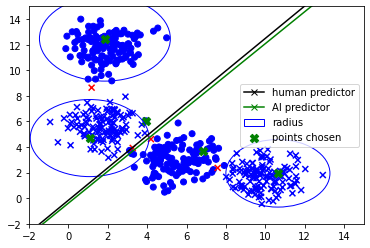

In [27]:
# plot teaching points and gammas
plot_teaching(teacher.human_learner, teaching_x, teaching_gammas)

## Greedy Radius Teaching
some errors with the guassian data for certain configurations, being updated currently.

In [37]:
teacher = TeacherExplainer(data_x_np, data_y_np, predicted_hum, predicted_mach, prior_rejector, kernel, metric_y, 0, 5)

In [ ]:
teaching_x, teaching_gammas, teaching_labels, teaching_indices = teacher.get_teaching_examples(True)

In [ ]:
# plot teaching points and gammas
plot_teaching(teacher.human_learner, teaching_x, teaching_gammas)